Project Instructions :A Python data science code sample, preferably in Jupyter notebook .ipynb format.
The notebook should show code and outputs.
Also include the .py scripts for any custom imported modules if applicable.
A brief description of the context behind the code sample,
how much of it was copied from other sources (e.g. Kaggle or tutorials), and
a TL;DR summary of findings.
If the description is already contained in the Jupyter notebook then
you don’t need to deliver a second file.

Evaluation Creterion :
The sample should be able to be run effectively on larger data sets,
have clear evidence of reusable functionality, and should be reproducible.
Also being able to explain how you did/would put the MLOps models into active production
is a key (as I mentioned we don't have a dedicated MLOps team currently and
would be responsible for productionalizing the fraud models you create).

[Click here to visit Dataset source](https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022/data)


Project Description
About Dataset
Business Problem
Business Objective
Model Evaluation

1.Income -Annual income of the applicant in quantiles. Ranges between  [0, 1]
2.name_email_similarity:Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between  [0, 1]
3.Number of months in previous registered address of the applicant -1 is a missing value
4.Months in currently registered address of the applicant. Ranges between [−1, 406] months (-1 is a missing
5.Applicant’s age in bins per decade (e.g, 20-29 is represented as 20).
6.Number of days passed since application was done. Ranges between [0, 78] days.
7.intended_balcon_amount:Initial transferred amount for application. Ranges between [−1, 108].
8.payment_type:Credit payment plan type. 5 possible (annonymized) values.
9.Number of applications within same zip code in last 4 weeks. Ranges between [1, 5767].
10.Velocity of total applications made in last 6 hours i.e.,avg number of applications per hour in the last 6
11.bank_branch_count_8w:Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2521].
12.date_of_birth_distinct_emails_4w:Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 42].
13.Internal score of application risk. Ranges between [−176, 387]
14.Current residential status for applicant. 7 possible (annonymized) values.
15.How old is previous account (if held) in months. Ranges between [−1, 31] months (-1 is a missing value).
16.Applicant’s proposed credit limit. Ranges between [200, 2000].
17.If origin country of request is different from bank’s country.
18.Source:Online source of application. Either browser(INTERNET) or mobile app (APP).
19.Length of user session in banking website in minutes. Ranges between [−1, 107] minutes
20.Operative system of device that made request. Possible values are: Windows, Macintox, Linux, X11, or other.
21.keep_alive_session-User option on session logout.
22.Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [0, 3].
23.Number of fraudulent applications with used device. Ranges between [0, 1].

real-world online bank account opening fraud detection dataset

In [44]:
# General-purpose libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# Data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Model evaluation and validation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve
)

# Oversampling for imbalanced data
from imblearn.over_sampling import SMOTE

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Feature selection
from sklearn.feature_selection import chi2, SelectFromModel

# Statistical tests
from scipy.stats import spearmanr, pearsonr, chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

# MLflow for experiment tracking
# import mlflow
# import mlflow.xgboost

# sys and py functions
import os
import joblib
import importlib
import model_util
from model_util import preprocess_data, smote, feature_selection, eval_model
from ml_utils import df_data_type, data_sanity, var_type, bivariate_analysis, correlation_check,negative_missing,num_dist_plot
importlib.reload(model_util)

pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<module 'model_util' from '/content/model_util.py'>

## Load the Dataset

In [11]:
df= pd.read_csv('Base.csv')
print("uploaded the credit card dataset")

uploaded the credit card dataset


# Exploratory Data Analysis (EDA)

Sanity checks

In [12]:
print("Shape of the dataset rows and columns :",df.shape)

Shape of the dataset rows and columns : (1000000, 32)


In [13]:
a,b=data_sanity(df)


Number of duplicated rows: 0
Number of rows with more than 60% missing data: 0
Number of columns with more than 30% missing data: 0


In [8]:
# drop the rows index with more that 60% data missing
df.drop(index=a, axis=0, inplace=True)

In [14]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163,1,BC,0,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154,1,BC,1,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89,1,BC,0,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91,0,BC,1,1,26,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [10]:
var_types=var_type(df)
print(f"We have {len(var_types['numeric'])} numerical features in the dataset")
var_types['numeric']
print(f"We have {len(var_types['categorical'])} categorical features in the dataset")
var_types['categorical']
print(f"We have some of numeric as boolean {len(var_types['boolean'])} features in the dataset")
var_types['boolean']
print(f"We have {len(var_types['string'])} string features in the dataset")


We have 26 numerical features in the dataset


['fraud_bool',
 'income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'bank_months_count',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'session_length_in_minutes',
 'keep_alive_session',
 'device_distinct_emails_8w',
 'month']

We have 5 categorical features in the dataset


['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

We have some of numeric as boolean 7 features in the dataset


['fraud_bool',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'foreign_request',
 'keep_alive_session']

We have 0 string features in the dataset


In [ ]:
#Statistical_summary of the columns

In [11]:
df.describe().round(4).transpose()
df.describe(include=["object", "bool"]).transpose()

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.0110,0.1044,0.0000,0.0000,0.0000,0.0000,1.0000
income,1000000.0,0.5627,0.2903,0.1000,0.3000,0.6000,0.8000,0.9000
name_email_similarity,1000000.0,0.4937,0.2891,0.0000,0.2252,0.4922,0.7556,1.0000
prev_address_months_count,1000000.0,16.7186,44.0462,-1.0000,-1.0000,-1.0000,12.0000,383.0000
current_address_months_count,1000000.0,86.5879,88.4066,-1.0000,19.0000,52.0000,130.0000,428.0000
customer_age,1000000.0,33.6891,12.0258,10.0000,20.0000,30.0000,40.0000,90.0000
days_since_request,1000000.0,1.0257,5.3818,0.0000,0.0072,0.0152,0.0263,78.4569
intended_balcon_amount,1000000.0,8.6615,20.2362,-15.5306,-1.1815,-0.8305,4.9842,112.9569
zip_count_4w,1000000.0,1572.6920,1005.3746,1.0000,894.0000,1263.0000,1944.0000,6700.0000
velocity_6h,1000000.0,5665.2966,3009.3807,-170.6031,3436.3658,5319.7693,7680.7178,16715.5654


,count,unique,top,freq
payment_type,1000000,5,AB,370554
employment_status,1000000,7,CA,730252
housing_status,1000000,7,BC,372143
source,1000000,2,INTERNET,992952
device_os,1000000,5,other,342728


#Target only 1% fraud cases, the highly imbalanced -  need for bootstrapping or handling imbalance - smote
#The income distribution (0.1 to 0.9)  indicating most individuals have middle-range incomes
#Address History: The current_address_months_count is more reliable with a mean of 86.8 months,
#while the prev_address_months_count contains many missing values -1
#Age Distribution: The average age of 33.7 years, with a range from 10 to 90, suggests a relatively young customer base.
#Credit Limits and Risk Scores:contain outliers and negative values

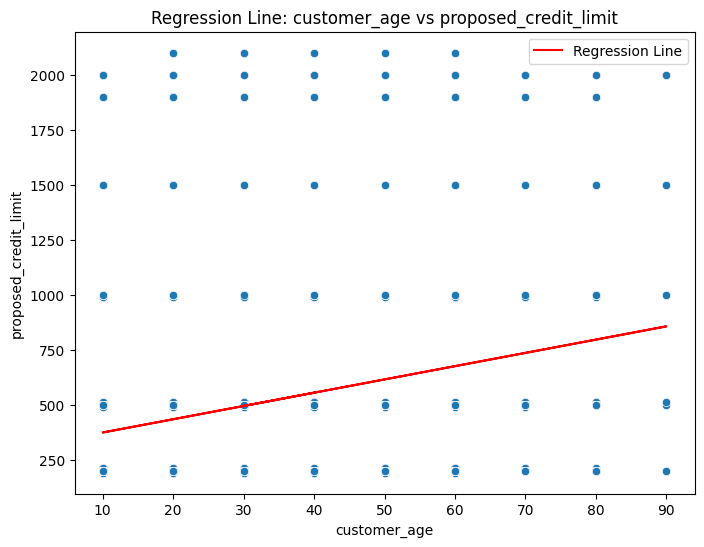

In [12]:

bivariate_analysis(df.copy(),'customer_age','proposed_credit_limit')

In [ ]:
#bivariate_analysis(df, 'velocity','proposed_credit_limit')

In [13]:
correlation_check(df.copy(), var_types['numeric'],threshold=0.5, print_map=False)

Variables with correlation >= 0.5 or <= -0.5:
velocity_24h and velocity_4w: 0.5391147330089973
velocity_24h and month: -0.5499192378767441
velocity_4w and velocity_24h: 0.5391147330089973
velocity_4w and month: -0.8481003026658848
credit_risk_score and proposed_credit_limit: 0.6061414475223359
proposed_credit_limit and credit_risk_score: 0.6061414475223359
month and velocity_24h: -0.5499192378767441
month and velocity_4w: -0.8481003026658848


/content/ml_utils.py:149: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  correlation_masked = correlation.applymap(lambda x: x if abs(x) >= threshold else None)


In [ ]:
# Drop: One of the variables between credit risk score and proposed credit limit.
# Drop: The month variable from the feature set, but use it to partition the dataset for training and testing.
# Keep: Both velocity 24h, velocity 4w, and zip_count_4w as they seem to offer complementary information, unless further analysis suggests redundancy.
# Drop: The 24h velocity if it's too correlated with 4w velocity (or only keep the more meaningful one based on model performance).

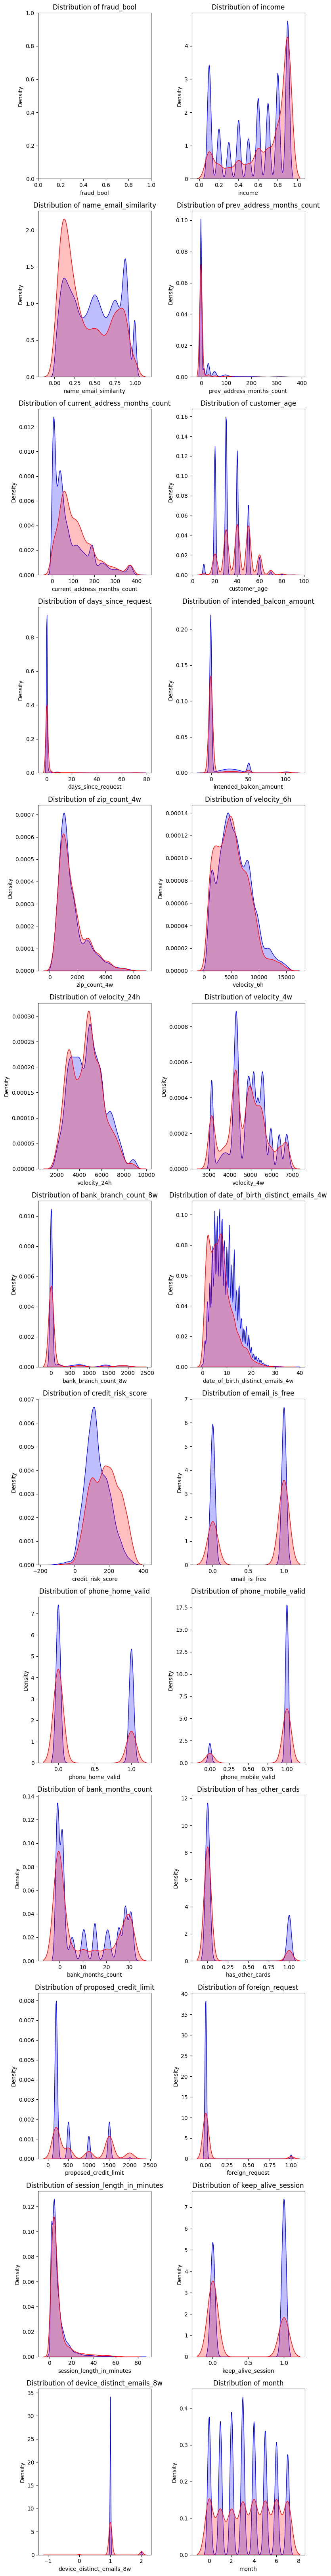

In [16]:
num_dist_plot(var_types['numeric'],df,'fraud_bool')

# Session Activity: Users who don't keep their session alive or frequently clear cookies are more likely to be flagged as fraud.
# Session Length: Shorter session lengths are associated with fraudulent applications.
# Banking History: Applicants with shorter banking histories are more likely to be fraudulent.
# Card Ownership: Applicants with no other bank accounts or  cards , suggesting a fraud risk.
# Address Stability: Frequent address changes or short residence durations increase the likelihood of fraud.
# This may reflect bias towards younger customers.while most customer is the dataset are mid young ages

In [17]:
col_list =list(df.columns)
negative_missing(df.copy() ,col_list,'fraud_bool')

                             feature  fraud_bool  missing_vals
0                         fraud_bool         0.0          0.00
1                         fraud_bool         1.0          0.00
2                             income         0.0          0.00
3                             income         1.0          0.00
4              name_email_similarity         0.0          0.00
5              name_email_similarity         1.0          0.00
6          prev_address_months_count         0.0         71.06
7          prev_address_months_count         1.0         91.89
8       current_address_months_count         0.0          0.43
9       current_address_months_count         1.0          0.13
10                      customer_age         0.0          0.00
11                      customer_age         1.0          0.00
12                days_since_request         0.0          0.00
13                days_since_request         1.0          0.00
14            intended_balcon_amount         0.0       

# Model

In [ ]:
#Configurations

In [23]:
RANDOM_STATE = 123
N_SPLITS = 5
target_column = 'fraud_bool'
file_path = os.getcwd()

In [38]:
# Preprocess data
X_train, y_train, X_test, y_test = preprocess_data(df.copy(), target_column)

# Perform over sampling
X_train_resampled, y_train_resampled = smote(X_train, y_train)

# Feature Selection
X_train_selected, X_test_selected = feature_selection(X_train_resampled, y_train_resampled,X_test)


Numerical Features: Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count'],
      dtype='object')
Categorical Features: Index(['payment_type', 'employment_status', 'housing_status', 'source',
       'device_os'],
      dtype='object')
Class distribution after SMOTE: [786838 786838]

Top Features by Importance:
 device_os_windows                   0.144210
housing_status_BC                   0.079129
housing_status_BB                   0.06

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [45]:
# K-Fold setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Models
models = {
    "Logistic Regression": LogisticRegression(random_state=123, max_iter=500),
    #"Random Forest": RandomForestClassifier(random_state=123, n_estimators=50),
    "XGBoost": XGBClassifier(random_state=123, eval_metric='logloss'),
    #"SVM": SVC(kernel='linear', random_state=123, probability=True)
}
# Evaluate different model
eval_model(models, X_train_selected, y_train_resampled, X_test_selected, y_test, kfold,RANDOM_STATE,file_path)


Training and Cross-Validating Logistic Regression...
Loading model from saved_models/Logistic Regression.joblib...
Test Set Accuracy: 0.8004
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    202133
           1       0.05      0.77      0.10      2878

    accuracy                           0.80    205011
   macro avg       0.52      0.78      0.49    205011
weighted avg       0.98      0.80      0.88    205011


Training and Cross-Validating XGBoost...
Loading model from saved_models/XGBoost.joblib...
Test Set Accuracy: 0.9828
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    202133
           1       0.25      0.12      0.16      2878

    accuracy                           0.98    205011
   macro avg       0.62      0.56      0.57    205011
weighted avg       0.98      0.98      0.98    205011



In [ ]:
print("\nNumber of selected features:", X_train_selected.shape[1])

In the final model set, I applied the SMOTE technique to handle the class imbalance issue by
oversampling the minority class


*  This method generates synthetic examples rather than duplicating existing

*   it does not duplicate existing ones, which helps the model generalize better
*   SMOTE should be used with caution in real-life scenarios, as more experimentation and business metric increase validation is needed.





 ** Feature Selection **:

*  chose the extratreeclassifier model
*  this automatically selects features based on importance


*   The importance of each feature is computed based on how much it helps to reduce the overall impurity at each node it splits
*   After training, the feature importance values for all trees are averaged (hence "mean importance"), giving an overall importance score for each feature


*   The final model used 17 features, selected based on the "mean" criterion in the feature selection algorithm.For feature selection







The model's performance, **measured by recall**, showed promising results, especially with **Logistic Regression,**
***given the imbalance in the dataset*** *italicized text*. to better understand model behavior,
though time constraints limited further experimentation.
*I would have tried h**yperparameter tuning xgb**,  d**ropping additional features** and **engineering new ones**, **shap charts , and svm** .*
but for this experiment, the results were pretty solid, so I’ll conclude it here for today.
